<a href="https://colab.research.google.com/github/binram077/AlephBetClassifier/blob/main/AlephBet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import random
import shutil
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

This project is an Aleph Bet classifier. I made for it a data set with 80 images of my handwritten Alephs and Bets.

In [2]:
BaseDir = 'Data/'
names = ['Aleph','Bet']

tf.random.set_seed(2)

In [3]:
if not os.path.isdir(BaseDir + '/train'):
  for name in names:
    os.makedirs(BaseDir + '/train/'+ name)
    os.makedirs(BaseDir + '/validation/'+ name)
    os.makedirs(BaseDir + '/test/'+ name)

In [ ]:
def ImAug(imFile):
  data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomWidth(factor = 0.1),
  layers.experimental.preprocessing.RandomHeight(factor = 0.1),
  layers.experimental.preprocessing.Resizing(90,90),
  ])
  im = Image.open(imFile)
  im = im.convert("RGB")
  im_arr = np.asarray(im)
  print(im_arr[0][1][0])
  im_arr = np.reshape(im_arr,[1,90,90,3])
  AugImArr = data_augmentation(im_arr)
  AugImArr = np.reshape(AugImArr,[90,90,3])
  return Image.fromarray((AugImArr).astype(np.uint8))


In [5]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,rotation_range=0.2)

In [6]:
orig_folders = ['0001/','0002/']
for folder_idx,folder in enumerate(orig_folders):
  files = os.listdir(BaseDir + folder)
  number_of_images = len([name for name in files])
  num_Tr = int(number_of_images*0.7 +0.5)
  num_Te = int(number_of_images*0.15 +0.5)
  num_V = number_of_images - num_Te - num_Tr
  for idx,file in enumerate(files):
    fileName = BaseDir + folder + file
    if idx < num_Tr:
      shutil.move(fileName,BaseDir+'/train/'+names[folder_idx])
    elif idx < num_Tr + num_Te:
      shutil.move(fileName,BaseDir+'/test/'+names[folder_idx])
    else:
      shutil.move(fileName,BaseDir+'/validation/'+names[folder_idx])


In [7]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,rotation_range=0.1,width_shift_range=5,height_shift_range=5,zoom_range=0.05)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_batches = train_gen.flow_from_directory(
    'Data/train/',
    class_mode = 'sparse',
    target_size = (90,90),
    batch_size = 4,
    shuffle = True,
    color_mode = 'rgba',
    classes = names
)

test_batches = train_gen.flow_from_directory(
    'Data/test/',
    class_mode = 'sparse',
    target_size = (90,90),
    batch_size = 4,
    shuffle = True,
    color_mode = 'rgba',
    classes = names
)

validation_batches = train_gen.flow_from_directory(
    'Data/validation/',
    class_mode = 'sparse',
    target_size = (90,90),
    batch_size = 4,
    shuffle = True,
    color_mode = 'rgba',
    classes = names
)

Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


In [8]:
trainBatch = train_batches[0]
testBatch = test_batches[0]
print(trainBatch[0].shape)
print(trainBatch[1])

(4, 90, 90, 4)
[0. 1. 1. 1.]


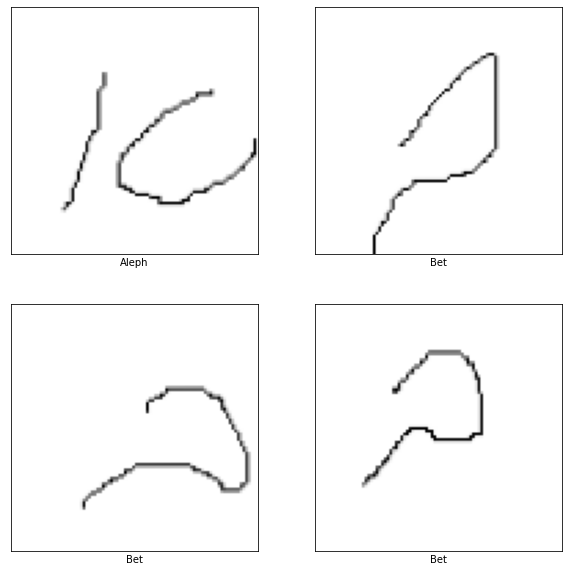

In [9]:
def show(batch,pred_labels =None):
  plt.figure(figsize=(10,10))
  for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch[0][i],cmap=plt.cm.binary)
    lbl = names[int(batch[1][i])]
    if pred_labels is not None:
      lbl += "/Pred: "+ names[int(pred_labels[i])]
    plt.xlabel(lbl)
  plt.show()

show(trainBatch)

In [10]:
model = keras.models.Sequential()
model.add(layers.Conv2D(20,(4,4),(1,1),activation='relu',input_shape = (90,90,4)))
model.add(layers.Conv2D(20,(2,2),(1,1),activation='relu',input_shape = (90,90,4)))
model.add(layers.AveragePooling2D(2,2))
model.add(layers.Conv2D(64,3,activation='relu'))
model.add(layers.Conv2D(20,(2,2),(1,1),activation='relu',input_shape = (90,90,4)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 87, 87, 20)        1300      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 86, 20)        1620      
_________________________________________________________________
average_pooling2d (AveragePo (None, 43, 43, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 64)        11584     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 20)        5140      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0

In [11]:
lossFunction = tf.losses.sparse_categorical_crossentropy
#lossFunction.from_logits = True
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']

model.compile(optimizer=optim,loss=lossFunction,metrics=metrics)

In [12]:
epochs = 20

model.fit(train_batches,validation_data = validation_batches,epochs=epochs,verbose=1)

Epoch 1/20
13/13 [==============================] - 2s 125ms/step - loss: 0.7913 - accuracy: 0.4686 - val_loss: 0.6896 - val_accuracy: 0.5455
Epoch 2/20
13/13 [==============================] - 1s 101ms/step - loss: 0.7003 - accuracy: 0.2591 - val_loss: 0.6905 - val_accuracy: 0.7273
Epoch 3/20
13/13 [==============================] - 1s 91ms/step - loss: 0.6930 - accuracy: 0.6053 - val_loss: 0.6871 - val_accuracy: 0.7273
Epoch 4/20
13/13 [==============================] - 1s 92ms/step - loss: 0.6820 - accuracy: 0.5848 - val_loss: 0.6512 - val_accuracy: 0.7273
Epoch 5/20
13/13 [==============================] - 1s 91ms/step - loss: 0.6682 - accuracy: 0.7791 - val_loss: 0.6983 - val_accuracy: 0.4545
Epoch 6/20
13/13 [==============================] - 1s 88ms/step - loss: 0.5916 - accuracy: 0.8113 - val_loss: 0.5903 - val_accuracy: 0.7273
Epoch 7/20
13/13 [==============================] - 1s 92ms/step - loss: 0.3750 - accuracy: 0.8695 - val_loss: 0.6377 - val_accuracy: 0.5455
Epoch 8/20


In [13]:
model.save("AlephBetModel.h5")

In [14]:
model.evaluate(test_batches,verbose=2)

3/3 - 0s - loss: 0.0083 - accuracy: 1.0000


[0.008264506235718727, 1.0]

In the next section I try my net on my brother's hebrew handwritten Alephs and Bets and I got 100% accuracy.

1c3.png


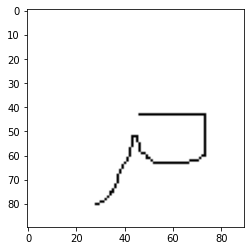

Bet
1c4.png


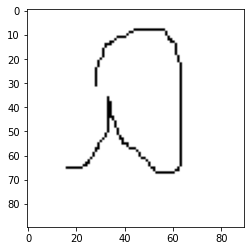

Bet
1c1.png


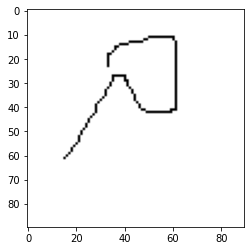

Bet
1c2.png


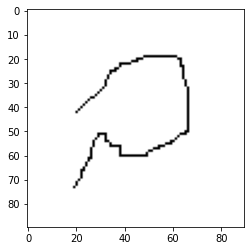

Bet
1G.png


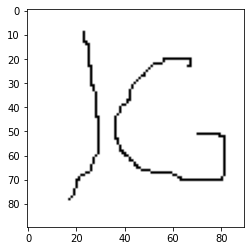

Aleph
1c1.png


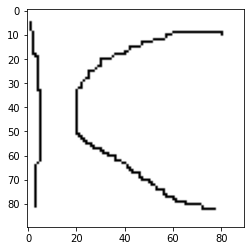

Aleph
1C.png


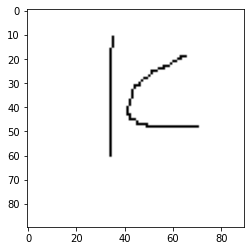

Aleph
1c2.png


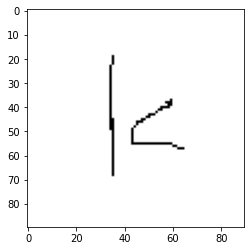

Aleph


In [16]:
CurFolder = 'shmuel/'
for Print_folder_index,Print_folder in enumerate(os.listdir(BaseDir + CurFolder)):
   for my_idx,file_name in enumerate(os.listdir(BaseDir + CurFolder + Print_folder)):
     print(file_name)
     im = Image.open(BaseDir + CurFolder + Print_folder +'/' + file_name,)
     im = im.convert("RGBA")
     plt.imshow(im)
     plt.show()
     im_array = np.asarray(im)
     Im_tensor = tf.convert_to_tensor(im_array)
     Im_tensor = tf.reshape(Im_tensor,[1,90,90,4])
     im_array = Im_tensor.numpy()
     print(names[np.argmax((model.predict(im_array)[0]))])

